In [1]:
import torchvision.transforms as transforms

from dataset import SegmentationDataset
from plot import show_sample

# Load data

In [2]:
transform = transforms.Compose([
    transforms.Resize((572, 572)),
    transforms.ToTensor()
])

image_dir = '../datasets/Brain_tumor_segmentation/images'
mask_dir = '../datasets/Brain_tumor_segmentation/masks'
dataset = SegmentationDataset(image_dir, mask_dir, transform)

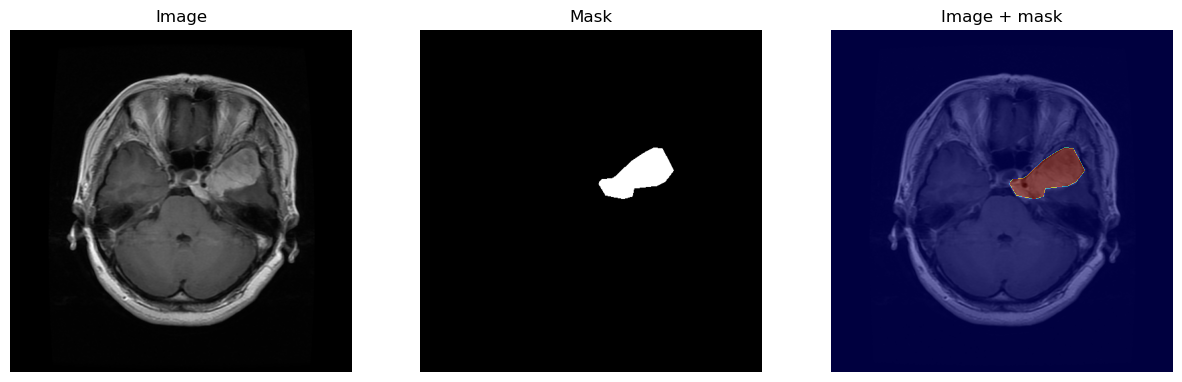

In [3]:
image, mask = dataset[0]
show_sample(image, mask)

In [4]:
image.shape

torch.Size([3, 512, 512])

## U-Net

In [5]:
import torch
import torch.nn as nn

In [6]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3),
            nn.ReLU(inplace=True)
        )
        
    def forward(self, x):
        return self.double_conv(x)

## Encoder

In [7]:
class Encoder(nn.Module):
    def __init__(self, in_channels=1):
        super().__init__()
        self.block1 = DoubleConv(in_channels, 64)
        self.block2 = DoubleConv(64, 128)
        self.block3 = DoubleConv(128, 256)
        self.block4 = DoubleConv(256, 512)
        self.bottleneck = DoubleConv(512, 1024)
        self.max_pool = nn.MaxPool2d(2)
        
    def forward(self, x):
        x = self.max_pool(self.block1(x))
        print(x.shape)
        x = self.max_pool(self.block2(x))
        print(x.shape)
        x = self.max_pool(self.block3(x))
        print(x.shape)
        x = self.max_pool(self.block4(x))
        print(x.shape)
        x = self.bottleneck(x)
        print(x.shape)
        return x

encoder = Encoder(in_channels=3)
output_encoder = encoder(image)

torch.Size([64, 254, 254])
torch.Size([128, 125, 125])
torch.Size([256, 60, 60])
torch.Size([512, 28, 28])
torch.Size([1024, 24, 24])


In [8]:
class Decoder(nn.Module):
    def __init__(self, in_channels=1024, out_channels=1):
        super().__init__()
        self.kernel = 2
        self.stride = 2
        
        self.up4 = self.conv_transpose(1024)
        self.block4 = DoubleConv(in_channels, 512)
        self.up3 = self.conv_transpose(512)
        self.block3 = DoubleConv(512, 256)
        self.up2 = self.conv_transpose(256)
        self.block2 = DoubleConv(256, 128)
        self.up1 = self.conv_transpose(128)
        self.block1 = DoubleConv(128, 64)
        self.conv = self.out_conv(out_channels)
        
    @staticmethod
    def conv_transpose(in_channels):
        return nn.ConvTranspose2d(in_channels, in_channels, kernel_size=2, stride=2)
    
    @staticmethod    
    def out_conv(out_channels):
        return nn.Conv2d(64, out_channels, kernel_size=1)
        
    def forward(self, x):
        x = self.up4(x)
        print(x.shape)
        x = self.block4(x)
        print(x.shape)
        x = self.up3(x)
        print(x.shape)
        x = self.block3(x)
        print(x.shape)
        x = self.up2(x)
        print(x.shape)
        x = self.block2(x)
        print(x.shape)
        x = self.up1(x)
        print(x.shape)
        x = self.block1(x)
        print(x.shape)
        x = self.conv(x)
        print(x.shape)
        return x
    
decoder = Decoder(in_channels=1024)
output_decoder = decoder(output_encoder)

torch.Size([1024, 48, 48])
torch.Size([512, 44, 44])
torch.Size([512, 88, 88])
torch.Size([256, 84, 84])
torch.Size([256, 168, 168])
torch.Size([128, 164, 164])
torch.Size([128, 328, 328])
torch.Size([64, 324, 324])
torch.Size([1, 324, 324])


## U-Net complete 
### Add torch.cat to decoder 

In [9]:
class Down(nn.Module):
    """Downscaling with max pool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.max_pool_conv = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.max_pool_conv(x)


class Up(nn.Module):
    """Up-scaling then double conv"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

In [12]:
class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(UNet, self).__init__()
        # Encoder
        self.enc1 = DoubleConv(in_channels, 64)
        self.enc2 = Down(64, 128)
        self.enc3 = Down(128, 256)
        self.enc4 = Down(256, 512)

        self.bottleneck = Down(512, 1024)

        self.up1 = Up(1024, 512)
        self.up2 = Up(512, 256)
        self.up3 = Up(256, 128)
        self.up4 = Up(128, 64)

        self.out_conv = nn.Conv2d(64, out_channels, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(e1)
        e3 = self.enc3(e2)
        e4 = self.enc4(e3)
        b = self.bottleneck(e4)
        # Decoder
        d4 = self.up1(b, e4)
        d3 = self.up2(d4, e3)
        d2 = self.up3(d3, e2)
        d1 = self.up4(d2, e1)
        x = self.out_conv(d1)
        return x

unet = UNet(in_channels=3, out_channels=1)
unet

UNet(
  (enc1): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (3): ReLU(inplace=True)
    )
  )
  (enc2): Down(
    (max_pool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
          (1): ReLU(inplace=True)
          (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
          (3): ReLU(inplace=True)
        )
      )
    )
  )
  (enc3): Down(
    (max_pool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
          (1): ReLU(inplace=True)
          (2): Conv2d(256, 256, ke